# Practical 1 - Motion Estimation

## Setup

### Import necessay libraries

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Import images

#### Utility functions

In [12]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to RGB
    :param path: path to image
    :return: image in RGB
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_image(img: np.ndarray, title: str = "") -> None:
    """
    Display image with matplotlib
    :param img: image to display
    :param title: title of the image
    """
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.show()

#### Load images and display chosen samples

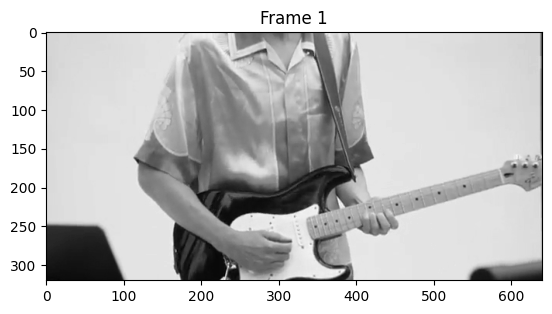

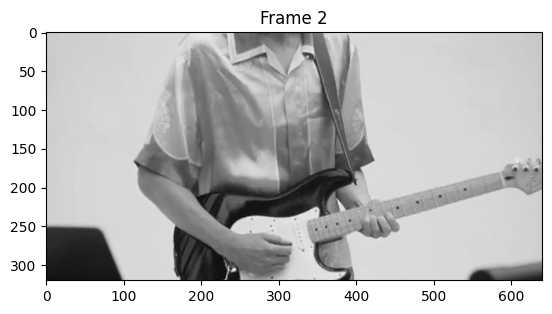

In [13]:
# Load two consecutive frames
frame1: np.ndarray = load_image("./images/LF000.jpg")
frame2: np.ndarray = load_image("./images/LF001.jpg")

# Display chosen frames
display_image(frame1, "Frame 1")
display_image(frame2, "Frame 2")

## A - Lucas-Kanade with colored images

### Gradients

In [14]:
# Spatial gradient
def spatial_gradient(img: np.ndarray) -> tuple:
    """
    Compute spatial gradient of an image

    :param img: image to compute spatial gradient
    :return: spatial gradient
    """
    g_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    g_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    return g_x, g_y

# Temporal gradient
def temporal_gradient(img1: np.ndarray, img2: np.ndarray) -> np.ndarray:
    """
    Compute temporal gradient of two images
    
    :param img1: first image
    :param img2: second image
    :return: temporal gradient
    """
    return img2 - img1

### Lucas-Kanade

In [15]:
# Implementation of the Lucas-Kanade method
def lucas_kanade(frame1, frame2, window_size=3) -> tuple:
    """
    Compute optical flow using the Lucas-Kanade method.

    :param frame1 (ndarray): First frame
    :param frame2 (ndarray): Second frame
    :param window_size (int): Size of the window used for computing the optical flow

    :return: Estimated displacement at each pixel
    """

    # Compute the gradients of the images
    g_x, g_y = spatial_gradient(frame1)
    g_t = temporal_gradient(frame1, frame2)

    # Initialize horizontal displacement vector components
    u = np.zeros_like(frame1)
    # Initialize vertical displacement vector components
    v = np.zeros_like(frame1)

    # Iterate over horizontal axe
    for i in range(frame1.shape[0]):
        # Iterate over verical axe
        for j in range(frame1.shape[1]):
            # Compute minimum window indices
            min_i = max(0, i - window_size)
            min_j = max(0, j - window_size)

            # Compute maximum window indices
            max_i = min(i + window_size, frame1.shape[0])
            max_j = min(j + window_size, frame1.shape[1])

            # Initialize A matrix (Lucas-Kanade matrix)
            A = np.array([g_x[min_i:max_i, min_j:max_j], g_y[min_i:max_i, min_j:max_j]])
            # print(A.shape)
            # Reshape the matrix into (2, image_width * image_height)
            A = A.reshape(A.shape[0], A.shape[1] * A.shape[2]).T

            # Initalize b (2D vector)
            b = - np.array(g_t[min_i:max_i, min_j:max_j])
            # Reshape b into a 1D vector
            b = b.reshape(b.shape[0] * b.shape[1])

            u[i, j], v[i, j] = np.linalg.lstsq(A.T @ A, A.T @ b, rcond=None)[0]

    return u, v

In [16]:
# Call the function
u, v = lucas_kanade(frame1=frame1, frame2=frame2, window_size=2)

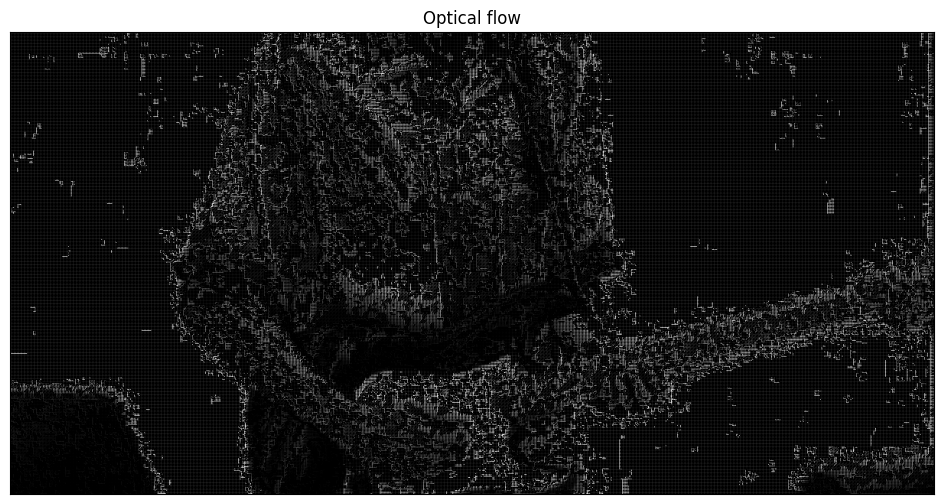

In [17]:
# Display optical flow
def display_optical_flow(frame: np.ndarray, u: np.ndarray, v: np.ndarray) -> None:
    """
    Display optical flow
    :param u: optical flow in x
    :param v: optical flow in y
    """

    _ , ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame, cmap='gray')
    ax.set_title("Optical flow")
    ax.set_xticks([])
    ax.set_yticks([])

    plt.quiver(u, v)
    
    plt.show()

display_optical_flow(frame1, u, v)